In [1]:
####################
### Dependencies ###
####################

import requests as rq
from dotenv import load_dotenv
import os
import json
import pandas as pd
from io import StringIO
from IPython.display import display
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import sqlite3 as sql
import psycopg as pg
import asyncio
import nest_asyncio
from scipy.stats import norm
import numpy as np
import subprocess

In [2]:
#####################
### General Setup ###
#####################

nest_asyncio.apply()
load_dotenv()

True

In [11]:
#################################
### Import data into Postgres ###
#################################

import_file = "/home/tev/Documents/precincts-with-results.geojson"
command = "/nix/store/v2qqya4p0fy042a260jq1lgbzvim4wpc-gdal-3.9.2/bin/ogr2ogr"
POSTGRES_DB = os.getenv("POSTGRES_DB")
POSTGRES_USER = os.getenv("POSTGRES_USER")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD")
POSTGRES_ENDPOINT = os.getenv("POSTGRES_ENDPOINT")
r = subprocess.run([command, "-f", "PostgreSQL", f"PG:host={POSTGRES_ENDPOINT} dbname={POSTGRES_DB} user={POSTGRES_USER} password={POSTGRES_PASSWORD}", import_file, "-nln", POSTGRES_DB, "-nlt", "PROMOTE_TO_MULTI"])
r.returncode

0

In [3]:
##################################
### Setup PostgreSQL Constants ###
##################################

# Make a connection to the database
activateCon = lambda : pg.Connection.connect(os.getenv("DB_URI"), cursor_factory=pg.ClientCursor)
con = activateCon()
cur = con.cursor()

In [12]:
###########################
### Setup PostgreSQL DB ###
###########################

# Initialize transformed tables AFTER IMPORTING THE GEOJSON FILE
cur.execute('''
    CREATE TABLE transformed AS
    SELECT
        ogc_fid AS id,
        ST_CollectionExtract(ST_MakeValid(ST_GeomFromWKB(wkb_geometry))) AS geo,
        substring(geoid from 1 for 2)::INT AS state,
        substring(geoid from 3 for 3)::INT AS county,
        votes_dem AS dem,
        votes_rep AS rep,
        votes_total AS total
    from jerry;

    INSERT INTO meta (state, type, level)
        SELECT state, 0, 0
        FROM transformed
        GROUP BY state;

    INSERT INTO groups (runid, geo, dem, rep, total)
        SELECT m.runid, t.geo, COALESCE(t.dem, 0), COALESCE(t.rep, 0), COALESCE(t.total, 0)
        FROM transformed AS t
        JOIN meta AS m ON t.state = m.state;
''')
con.commit()
con.close()

In [4]:
con = activateCon()
cur = con.cursor()

cur.execute('''
    SELECT * FROM meta;
''').fetchall()



[(1, 44, 0, None, 0, None),
 (2, 11, 0, None, 0, None),
 (3, 42, 0, None, 0, None),
 (4, 40, 0, None, 0, None),
 (5, 9, 0, None, 0, None),
 (6, 15, 0, None, 0, None),
 (7, 26, 0, None, 0, None),
 (8, 48, 0, None, 0, None),
 (9, 19, 0, None, 0, None),
 (10, 30, 0, None, 0, None),
 (11, 21, 0, None, 0, None),
 (12, 17, 0, None, 0, None),
 (13, 37, 0, None, 0, None),
 (14, 28, 0, None, 0, None),
 (15, 5, 0, None, 0, None),
 (16, 56, 0, None, 0, None),
 (17, 29, 0, None, 0, None),
 (18, 54, 0, None, 0, None),
 (19, 4, 0, None, 0, None),
 (20, 34, 0, None, 0, None),
 (21, 10, 0, None, 0, None),
 (22, 35, 0, None, 0, None),
 (23, 45, 0, None, 0, None),
 (24, 6, 0, None, 0, None),
 (25, 39, 0, None, 0, None),
 (26, 36, 0, None, 0, None),
 (27, 31, 0, None, 0, None),
 (28, 50, 0, None, 0, None),
 (29, 13, 0, None, 0, None),
 (30, 16, 0, None, 0, None),
 (31, 41, 0, None, 0, None),
 (32, 46, 0, None, 0, None),
 (33, 32, 0, None, 0, None),
 (34, 53, 0, None, 0, None),
 (35, 38, 0, None, 0, None)

In [35]:
loop = asyncio.get_event_loop()

# Define asynchronous function decorator to allow for asynchronous execution within the loop
def asyn(f):
    global loop
    def wrapped(*args, **kwargs):
        global loop
        return loop.run_in_executor(None, f, *args, **kwargs)
    return wrapped

def aawait(f):
    global loop
    return loop.run_until_complete(f)

In [43]:


runs = {
    "ohio": ["{{880, 30}, {88, 30}}", 25], # Ohio 30x30 trial
    "california": ["{{500, 30}, {58, 30}}", 24], # California 30x30 trial
    "wisconsin": ["{{700, 30}, {72, 30}}", 44], # Wisconsin 30x30 trial
    "penns": ["{{700, 30}, {67, 30}}", 3], # Penns 30x30 trial
    "nevada": ["{{200, 30}, {17, 30}}", 33], # Nevada 30x30 trial
    "arizona": ["{{150, 30}, {15, 30}}", 19], # Arizona 30x30 trial
    "illinois": ["{{1000, 30}, {102, 30}}", 12], # Illinois 30x30 trial
    "texas": ["{{1000, 30}, {254, 30}}", 8], # Texas 30x30 trial
    "kansas": ["{{700, 30}, {105, 30}}", 41] # Kansas 30x30 trial
}

@asyn
def do_state(runid):
    global runs
    con = activateCon()
    cur = con.cursor()
    id = cur.execute("select create_layers(%(layers)s::INT[][], %(runid)s);", {'layers': runs[runid][0], 'runid': runs[runid][1]}).fetchall()[0][0]
    con.commit()
    con.close()
    print(id)


tasks = [do_state(state) for state in ["california", "wisconsin", "penns", "nevada", "arizona", "illinois", "texas", "kansas"]]
while True:
    print(f"Working... {[i.done() for i in tasks]}")
    if all([i.done() for i in tasks]):
        break
    aawait(asyncio.sleep(2))

Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]


In [24]:
con.rollback()

In [17]:
con = activateCon()
cur = con.cursor()

d = cur.execute("select %(arr)s::INT[][];", {'arr': "{{1, 2}, {3, 4}, {5, 6}}"}).fetchall()
print(d)

con.commit()
con.close()

[([[1, 2], [3, 4], [5, 6]],)]


In [10]:
con = activateCon()
cur = con.cursor()

id = 1
data = pd.DataFrame(cur.execute("select * from results where resid = %(id)s;", {'id': id}).fetchall())
data = data.set_axis(['runid', 'resid', 'dem', 'rep', 'total'], axis=1)
print(data)

con.commit()
con.close()

     runid  resid  dem  rep  total
0       78      1   11   78     89
1       79      1   12   77     89
2       80      1   11   78     89
3       81      1   10   79     89
4       82      1    9   80     89
..     ...    ...  ...  ...    ...
895    973      1   10   79     89
896    974      1   10   79     89
897    975      1   11   78     89
898    976      1   10   79     89
899    977      1   10   79     89

[900 rows x 5 columns]
0       78
1       79
2       80
3       81
4       82
      ... 
895    973
896    974
897    975
898    976
899    977
Name: runid, Length: 900, dtype: int64


Red_mean, Red_std:  78.65666666666667 1.4058949465260226
Blue_mean, Blue_std:  10.343333333333334 1.4058949465260226


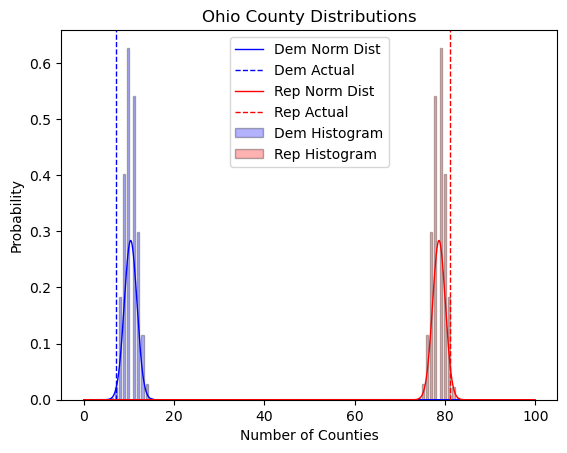

In [26]:
x_axis = np.arange(0, 100, 0.1)
bins = 20

blue_mean = data["dem"].mean()
blue_std = data["dem"].std()
actual_blue= 7    # placeholder

red_mean = data["rep"].mean()
red_std = data["rep"].std()
actual_red= 81    # placeholder

print("Red_mean, Red_std: ", red_mean, red_std)
print("Blue_mean, Blue_std: ", blue_mean, blue_std)

#combined plot
plt.hist(data["dem"], bins=bins, color='b', density=True, alpha=0.3, edgecolor='black')
plt.hist(data["rep"], bins=bins, color='r', density=True, alpha=0.3, edgecolor='black')
plt.plot(x_axis, norm.pdf(x_axis, loc=data["dem"].mean(), scale=data["dem"].std()), color='b', linewidth=1)
plt.axvline(x=actual_blue, color='b', linestyle='dashed', linewidth=1)
plt.plot(x_axis, norm.pdf(x_axis, loc=data["rep"].mean(), scale=data["rep"].std()), color='r', linewidth=1)
plt.axvline(x=actual_red, color='r', linestyle='dashed', linewidth=1)
plt.title("Ohio County Distributions")
plt.xlabel("Number of Counties")
plt.ylabel("Probability")
plt.legend(["Dem Norm Dist", "Dem Actual", "Rep Norm Dist", "Rep Actual", "Dem Histogram", "Rep Histogram"], loc="upper center")
plt.show()